# Example: Van der Pol Oscillator from gillijns2006ensemble
Here, I first try the original EnKF with different ensemble sizes. 
This is a low-order example.

## Define the EnFK function
This defines the original EnKF for non-linear systems. 
Note that `process_model` and `observation_model` are problem dependent. 
The function defined here is for $y$ being a real value (1 dim).

In [128]:
import numpy as np
import matplotlib.pyplot as plt

class EnsembleKalmanFilter:
    def __init__(self, ensemble_size, state_dim, process_model, observation_model, R, Q):
        """
        :param ensemble_size: Number of ensemble members
        :param state_dim: Dimensionality of the state vector
        :param process_model: Function to predict the next state
        :param observation_model: Function to map the state to observations
        :param R: Observation noise covariance matrix
        :param Q: Process noise covariance matrix
        """
        self.ensemble_size = ensemble_size
        self.state_dim = state_dim
        self.process_model = process_model
        self.observation_model = observation_model
        self.R = R  # Observation noise covariance
        self.Q = Q  # Process noise covariance
        self.ensemble = None

    def initialize_ensemble(self, initial_state, spread=1.0):
        """
        Initializes the ensemble around an initial state.
        :param initial_state: The initial state vector (numpy array)
        :param spread: Spread for random perturbations around the initial state
        """
        self.ensemble = np.array([initial_state + spread * np.random.randn(self.state_dim) for _ in range(self.ensemble_size)])

    def predict(self):
        """
        Applies the process model to predict the next state for each ensemble member.
        """
        for i in range(self.ensemble_size):
            if np.isscalar(self.Q) or self.Q.ndim == 1:
                process_noise = np.random.normal(0, self.Q, self.state_dim)
            else:
                process_noise = np.random.multivariate_normal(np.zeros(self.state_dim), self.Q)
            self.ensemble[i] = self.process_model(self.ensemble[i]) + process_noise

    def update(self, observation, inflation):
        if np.isscalar(observation):
            observation = np.atleast_1d(observation)
        """
        Updates the ensemble based on the observation.
        :param observation: Observation vector (numpy array)
        """
        # Compute ensemble mean and observation mean
        ensemble_mean = np.mean(self.ensemble, axis=0)
        ensemble_observations = np.array([self.observation_model(member) for member in self.ensemble])
        observation_mean = np.mean(ensemble_observations, axis=0)

        # Compute innovation covariance and Kalman gain
        P_yy = (inflation**2) * np.cov(ensemble_observations, rowvar=False) + self.R
        # Extract only the covariance part
        P_xy = (inflation**2) * np.cov(self.ensemble.T, ensemble_observations.T)[:self.state_dim, self.state_dim:]

        # Handle 1D case for P_yy and P_xy
        if np.isscalar(P_yy) or P_yy.ndim == 0:
            P_yy = P_yy.reshape(1, 1)
        if np.isscalar(P_xy) or P_xy.ndim == 0:
            P_xy = P_xy.reshape(-1, 1)

        K = P_xy @ np.linalg.inv(P_yy)

        # Update each ensemble member
        for i in range(self.ensemble_size):
            if np.isscalar(self.R):
                innovation_noise = np.random.normal(0, self.R, 1) if np.isscalar(observation) else np.random.normal(0, self.R, len(observation))
            elif self.R.ndim == 1:
                innovation_noise = np.random.normal(0, self.R, len(observation))
            else:
                innovation_noise = np.random.multivariate_normal(np.zeros(len(observation)), self.R)
            innovation = observation + innovation_noise - ensemble_observations[i]
            if np.isscalar(innovation) or innovation.ndim == 0:
                innovation = np.array([innovation])
            self.ensemble[i] += (K @ innovation).flatten()

    def get_state_estimate(self):
        """
        Returns the current state estimate (mean of the ensemble).
        """
        return np.mean(self.ensemble, axis=0)
    
    def get_variance_estimate(self):
        return np.std(self.ensemble, axis=0)


## Define processes for the problem
The process is given by
$$
x_{k+1}=f\left(x_k\right),
$$

where $x_k=\left[\begin{array}{ll}x_{1, k} & x_{2, k}\end{array}\right]^{\mathrm{T}}$,

$$
f\left(x_k\right)=\left[\begin{array}{c}
x_{1, k}+h x_{2, k} \\
x_{2, k}+h\left(\alpha\left(1-x_{1, k}^2\right) x_{2, k}-x_{1, k}\right)
\end{array}\right],
$$

and $h$ is the step size. We assume that the Van der Pol oscillator is driven by $w_k$, that is,

$$
x_{k+1}=f\left(x_k\right)+w_k,
$$

where $w_k \in \mathbb{R}^2$ is zero-mean white Gaussian noise with covariance matrix $Q \in \mathbb{R}^{2 \times 2}$. We assume that for all $k \geqslant 0$, measurements of either $x_{1, k}$ or $x_{2, k}$ are available so that

$$
y_k=C x_k+v_k,
$$

where $v_k \in \mathbb{R}$ is zero mean white Gaussian noise with covariance $R>0$ and $C$ selects $x_{1, k}$ or $x_{2, k}$. The objective

In [129]:
# State transition function for Van der Pol oscillator
# The models are without noises
def process_model(state):
    x1, x2 = state
    dx1 = x1 + h * x2
    dx2 = x2 + h * (alpha * (1 - x1**2) * x2 - x1)
    return np.array([dx1, dx2])

def observation_model(state):
    return C @ state

## Generate data and set parameters as in the paper


In [130]:
# Define parameters
np.random.seed(999)
state_dim = 2
R = 0.5 # Observation noise covariance
Q = np.diag([0.0262, 0.008])  # Process noise covariance
alpha = 1.0  # Parameter for the Van der Pol oscillator
h = 0.1      # Step size
C = np.array([0, 1])
T = 500  # Total time steps
inflation = 1
initial_state = np.zeros(state_dim)

# Generate data and the true states
w = np.random.multivariate_normal(np.zeros(state_dim), Q)
true_states = np.array([process_model(initial_state) + w])
v = np.random.normal(0, R)
observations = np.array([observation_model(true_states[0,])+ v])

for t in range(T):
    w = np.random.multivariate_normal(np.zeros(state_dim), Q)
    true_state = process_model(true_states[t,]) + w
    true_states = np.append(true_states, [true_state], axis=0)
    if t+1 == T:
        break
    v = np.random.normal(0, R)
    observation = observation_model(true_states[t+1]) + v
    observations = np.append(observations, [observation], axis=0)

observations = observations.reshape(-1, 1)


## Implement and visualize the original EnKF with ensemble sizes (10, 30, 50)
Implement EnKF.


In [131]:
# Implement the EnFK
np.random.seed(999)

# Ensemble size 30
ensemble_size = 30
enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R, Q)
enkf.initialize_ensemble(initial_state)
result_x1_30 = []
result_x2_30 = []
var_x1_30 = []
var_x2_30 = []
for observation in observations:
  enkf.predict()
  enkf.update(observation, inflation=1)
  result_x1_30.append(enkf.get_state_estimate()[0])
  result_x2_30.append(enkf.get_state_estimate()[1])
  var_x1_30.append(enkf.get_variance_estimate()[0])
  var_x2_30.append(enkf.get_variance_estimate()[1])

# Ensemble size 10
ensemble_size = 10
enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R, Q)
enkf.initialize_ensemble(initial_state)
result_x1_10 = []
result_x2_10 = []
for observation in observations:
  enkf.predict()
  enkf.update(observation, inflation=1)
  result_x1_10.append(enkf.get_state_estimate()[0])
  result_x2_10.append(enkf.get_state_estimate()[1])

# Ensemble size 5
ensemble_size = 5
enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R, Q)
enkf.initialize_ensemble(initial_state)
result_x1_5 = []
result_x2_5 = []
for observation in observations:
  enkf.predict()
  enkf.update(observation, inflation=1)
  result_x1_5.append(enkf.get_state_estimate()[0])
  result_x2_5.append(enkf.get_state_estimate()[1])

Visualize and compute the MSEs and confidence interval.

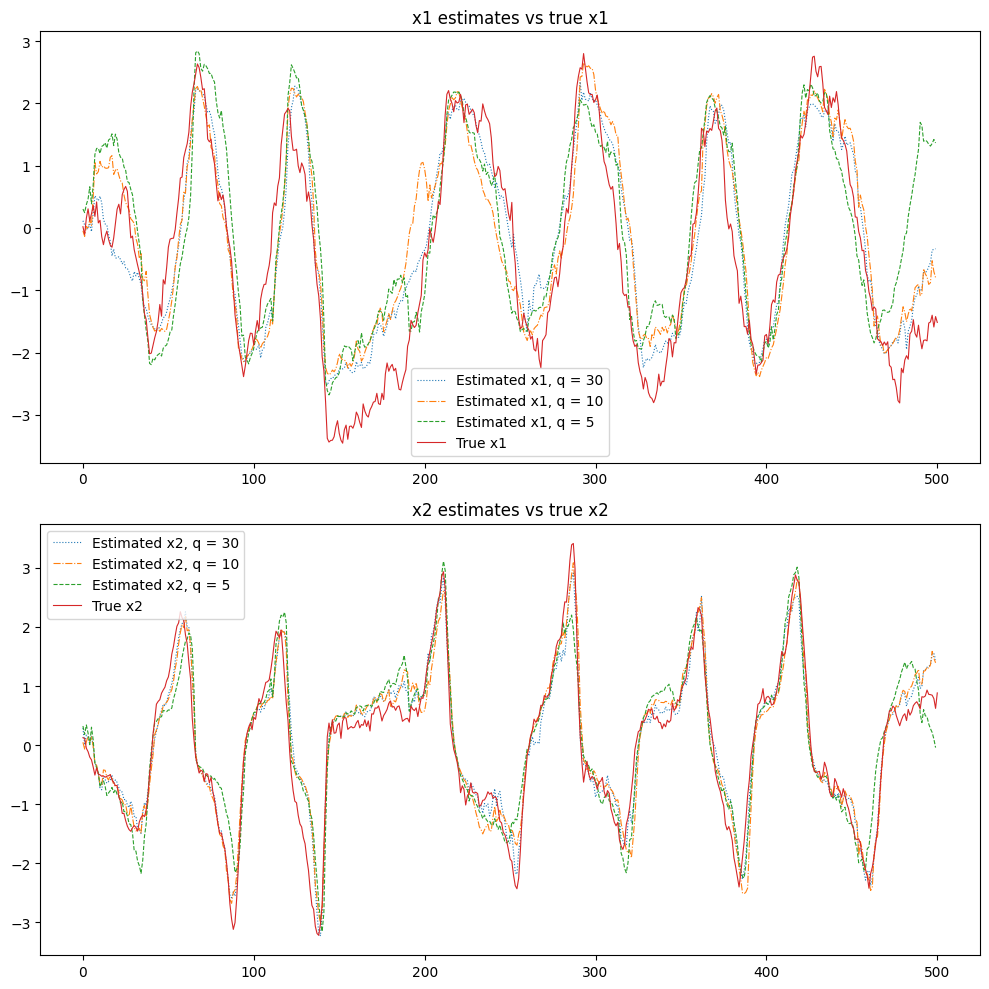

MSE x1, q = 30: 0.5
MSE x2, q = 30: 0.18
MSE x1, q = 10: 0.68
MSE x2, q = 10: 0.24
MSE x1, q = 5: 1.0
MSE x2, q = 5: 0.29


In [132]:
# Visualize
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot data in each subplot
axs[0].plot(result_x1_30, linestyle=':', linewidth=0.8, label="Estimated x1, q = 30")
axs[0].plot(result_x1_10, linestyle='-.', linewidth=0.8, label="Estimated x1, q = 10")
axs[0].plot(result_x1_5, linestyle='--', linewidth=0.8, label="Estimated x1, q = 5")
axs[0].plot(true_states[:, 0], linewidth=0.8, label="True x1")
axs[0].set_title("x1 estimates vs true x1")
axs[0].legend()


axs[1].plot(result_x2_30, linestyle=':', linewidth=0.8, label="Estimated x2, q = 30")
axs[1].plot(result_x2_10, linestyle='-.', linewidth=0.8, label="Estimated x2, q = 10")
axs[1].plot(result_x2_5, linestyle='--', linewidth=0.8, label="Estimated x2, q = 5")
axs[1].plot(true_states[:, 1], linewidth=0.8, label="True x2")
axs[1].set_title("x2 estimates vs true x2")
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("EnKF_different_ensemble_sizes.png")
plt.show()


# MSEs
MSE_x1_30 = np.mean((np.array(result_x1_30) - true_states[1:, 0])**2)
MSE_x2_30 = np.mean((np.array(result_x2_30) - true_states[1:, 1])**2)
MSE_x1_10 = np.mean((np.array(result_x1_10) - true_states[1:, 0])**2)
MSE_x2_10 = np.mean((np.array(result_x2_10) - true_states[1:, 1])**2)
MSE_x1_5 = np.mean((np.array(result_x1_5) - true_states[1:, 0])**2)
MSE_x2_5 = np.mean((np.array(result_x2_5) - true_states[1:, 1])**2)

print(f"MSE x1, q = 30: {MSE_x1_30:.2}")
print(f"MSE x2, q = 30: {MSE_x2_30:.2}")
print(f"MSE x1, q = 10: {MSE_x1_10:.2}")
print(f"MSE x2, q = 10: {MSE_x2_10:.2}")
print(f"MSE x1, q = 5: {MSE_x1_5:.2}")
print(f"MSE x2, q = 5: {MSE_x2_5:.2}")

From this figure, we observe that a larger ensemble size leads to a better fit.
The MSEs computed for $x_1$ and $x_2$ are reported as follows:

**MSEs for Different Ensemble Sizes (EnKF)**

| Ensemble Size ($q$) | MSE ($x_1$) | MSE ($x_2$) |
|-------------------|----------|----------|
| 30                | 0.5      | 0.18     |
| 10                | 0.68     | 0.24     |
| 5                 | 1.0      | 0.29     |

We chose $q$ such that it aligns the $q$ used in [[gillijns2006ensemble]]. For a high dimensional problem 50~100 ensemble members is typically enough [[gillijns2006ensemble.1.6]]. This justifies the use of $q = 30$ here.

This result was expected as more $q$ generally gives a better approximation of the covariance of forecast states since the sampling error becomes smaller. In fact, $q \leq 10$ can capture the trend well. It is worth mentioning that EnKF generally underestimates the posterior covariance of the posterior state [[katzfuss2016understanding]], especially when the ensmeble size is small. As can be seen in the osilation of EnKF estimates is smaller than that of the true states. This problem can be resolved be variance inflation Sec7.6.2. [[bach2024inverse]] and Sec 10.3. [[evensen2022data]].

## Implment different variants of EnKF with $q = 30$ for 300 independent runs


In [133]:
MSE_R2_better_than_R_x1 = 0
MSE_R2_better_than_R_x2 = 0
MSE_Inf_better_than_R_x1 = 0
MSE_Inf_better_than_R_x2 = 0
coverage_R2_better_than_R_x1 = 0
coverage_R2_better_than_R_x2 = 0
coverage_Inf_better_than_R_x1 = 0
coverage_Inf_better_than_R_x2 = 0
num_experiments = 100
MSE_x1_R_list =[]
MSE_x2_R_list = []
MSE_x1_R2_list = []
MSE_x2_R2_list = []
MSE_x1Inf_list = []
MSE_x2Inf_list = []
coverage_x1_R_list = []
coverage_x2_R_list = []
coverage_x1_R2_list = []
coverage_x2_R2_list = []
coverage_x1Inf_list = []
coverage_x2Inf_list = []

diff_MSE_2R_R_x1 = 0
diff_MSE_2R_R_x2 = 0

for seed in range(750, 750+num_experiments):
    np.random.seed(seed)
    # Generate data and the true states
    state_dim = 2
    R = 0.5 # Observation noise covariance
    Q = np.diag([0.0262, 0.008])  # Process noise covariance
    alpha = 1.0  # Parameter for the Van der Pol oscillator
    h = 0.1      # Step size
    C = np.array([0, 1])
    T = 500  # Total time steps
    inflation = 1
    initial_state = np.zeros(state_dim)

    # Generate data and the true states
    w = np.random.multivariate_normal(np.zeros(state_dim), Q)
    true_states = np.array([process_model(initial_state) + w])
    v = np.random.normal(0, R)
    observations = np.array([observation_model(true_states[0,])+ v])

    for t in range(T):
        w = np.random.multivariate_normal(np.zeros(state_dim), Q)
        true_state = process_model(true_states[t,]) + w
        true_states = np.append(true_states, [true_state], axis=0)
        if t+1 == T:
            break
        v = np.random.normal(0, R)
        observation = observation_model(true_states[t+1]) + v
        observations = np.append(observations, [observation], axis=0)

    observations = observations.reshape(-1, 1)
    
    # Run EnKF
    ensemble_size = 2000
    enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R, Q)
    enkf.initialize_ensemble(initial_state)
    result_x1_30 = []
    result_x2_30 = []
    for observation in observations:
        enkf.predict()
        enkf.update(observation, inflation=1)
        result_x1_30.append(enkf.get_state_estimate()[0])
        result_x2_30.append(enkf.get_state_estimate()[1])

    # Run EnKF with 2R
    R1 = R*2  # Observation noise covariance
    ensemble_size = 2000

    # Instantiate and initialize EnKF
    enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R1, Q)
    enkf.initialize_ensemble(initial_state)

    result_x1_two = []
    result_x2_two = []
    var_x1_30_two = []
    var_x2_30_two = []
    for observation in observations:
        enkf.predict()
        enkf.update(observation, inflation=1)
        result_x1_two.append(enkf.get_state_estimate()[0])
        result_x2_two.append(enkf.get_state_estimate()[1])
        var_x1_30_two.append(enkf.get_variance_estimate()[0])
        var_x2_30_two.append(enkf.get_variance_estimate()[1])

    # Run EnKF with inflation

    # Instantiate and initialize EnKF
    enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R, Q)
    enkf.initialize_ensemble(initial_state)

    result_x1Inf = []
    result_x2Inf = []
    var_x1_30Inf = []
    var_x2_30Inf = []
    for observation in observations:
        enkf.predict()
        enkf.update(observation, inflation=2)
        result_x1Inf.append(enkf.get_state_estimate()[0])
        result_x2Inf.append(enkf.get_state_estimate()[1])
        var_x1_30Inf.append(enkf.get_variance_estimate()[0])
        var_x2_30Inf.append(enkf.get_variance_estimate()[1])

    # MSEs
    MSE_x1_30 = np.mean((np.array(result_x1_30) - true_states[1:, 0])**2)
    MSE_x2_30 = np.mean((np.array(result_x2_30) - true_states[1:, 1])**2)
    MSE_x1_two = np.mean((np.array(result_x1_two) - true_states[1:, 0])**2)
    MSE_x2_two = np.mean((np.array(result_x2_two) - true_states[1:, 1])**2)
    MSE_x1Inf = np.mean((np.array(result_x1Inf) - true_states[1:, 0])**2)
    MSE_x2Inf = np.mean((np.array(result_x2Inf) - true_states[1:, 1])**2)

    MSE_x1_R_list.append(MSE_x1_30)
    MSE_x2_R_list.append(MSE_x2_30)
    MSE_x1_R2_list.append(MSE_x1_two)
    MSE_x2_R2_list.append(MSE_x2_two)
    MSE_x1Inf_list.append(MSE_x1Inf)
    MSE_x2Inf_list.append(MSE_x2Inf)

    # Coverage probabilities
    coverage_x1 = 0
    coverage_x2 = 0
    for i in range(T):
        if true_states[i, 0] >= result_x1_30[i] - var_x1_30[i] and true_states[i, 0] <= result_x1_30[i] + var_x1_30[i]:
            coverage_x1 += 1
        if true_states[i, 1] >= result_x2_30[i] - var_x2_30[i] and true_states[i, 1] <= result_x2_30[i] + var_x2_30[i]:
            coverage_x2 += 1
    coverage_x1 /= T
    coverage_x2 /= T

    # For 2R
    coverage_x1_two = 0
    coverage_x2_two = 0
    for i in range(T):
        if true_states[i, 0] >= result_x1_two[i] - var_x1_30_two[i] and true_states[i, 0] <= result_x1_two[i] + var_x1_30_two[i]:
            coverage_x1_two += 1
        if true_states[i, 1] >= result_x2_two[i] - var_x2_30_two[i] and true_states[i, 1] <= result_x2_two[i] + var_x2_30_two[i]:
            coverage_x2_two += 1
    coverage_x1_two /= T
    coverage_x2_two /= T
    
    # For inflation
    coverage_x1Inf = 0
    coverage_x2Inf = 0
    for i in range(T):
        if true_states[i, 0] >= result_x1Inf[i] - var_x1_30Inf[i] and true_states[i, 0] <= result_x1Inf[i] + var_x1_30Inf[i]:
            coverage_x1Inf += 1
        if true_states[i, 1] >= result_x2Inf[i] - var_x2_30Inf[i] and true_states[i, 1] <= result_x2Inf[i] + var_x2_30Inf[i]:
            coverage_x2Inf += 1
    coverage_x1Inf /= T
    coverage_x2Inf /= T

    coverage_x1_R_list.append(coverage_x1)
    coverage_x2_R_list.append(coverage_x2)
    coverage_x1_R2_list.append(coverage_x1_two)
    coverage_x2_R2_list.append(coverage_x2_two)
    coverage_x1Inf_list.append(coverage_x1Inf)
    coverage_x2Inf_list.append(coverage_x2Inf)

    if MSE_x1_two < MSE_x1_30:
        MSE_R2_better_than_R_x1 += 1
    if MSE_x2_two < MSE_x2_30:
        MSE_R2_better_than_R_x2 += 1
    if MSE_x1Inf < MSE_x1_30:
        MSE_Inf_better_than_R_x1 += 1
    if MSE_x2Inf < MSE_x2_30:
        MSE_Inf_better_than_R_x2 += 1
    if coverage_x1_two > coverage_x1:
        coverage_R2_better_than_R_x1 += 1
    if coverage_x2_two > coverage_x2:
        coverage_R2_better_than_R_x2 += 1
    if coverage_x1Inf > coverage_x1:
        coverage_Inf_better_than_R_x1 += 1
    if coverage_x2Inf > coverage_x2:
        coverage_Inf_better_than_R_x2 += 1

    diff_MSE_2R_R_x1 += abs(MSE_x1_30 - MSE_x1_two)
    diff_MSE_2R_R_x2 += abs(MSE_x2_30 - MSE_x2_two)

    # Print the results
    print(f"Seed {seed}--------------------------------")
    print(f"MSE x1, q = {ensemble_size}: {MSE_x1_30:.2}")
    print(f"MSE x2, q = {ensemble_size}: {MSE_x2_30:.2}")
    print(f"MSE x1, 2R: {MSE_x1_two:.2}")
    print(f"MSE x2, 2R: {MSE_x2_two:.2}")
    # print(f"MSE x1, inflation: {MSE_x1Inf:.2}")
    # print(f"MSE x2, inflation: {MSE_x2Inf:.2}")
    print(f"Coverage x1, q = {ensemble_size}: {coverage_x1:.2}")
    print(f"Coverage x2, q = {ensemble_size}: {coverage_x2:.2}")
    print(f"Coverage x1, 2R: {coverage_x1_two:.2}")
    print(f"Coverage x2, 2R: {coverage_x2_two:.2}")
    # print(f"Coverage x1, inflation: {coverage_x1Inf:.2}")
    # print(f"Coverage x2, inflation: {coverage_x2Inf:.2}")




Seed 750--------------------------------
MSE x1, q = 2000: 0.72
MSE x2, q = 2000: 0.16
MSE x1, 2R: 0.78
MSE x2, 2R: 0.17
Coverage x1, q = 2000: 0.64
Coverage x2, q = 2000: 0.69
Coverage x1, 2R: 0.82
Coverage x2, 2R: 0.91
Seed 751--------------------------------
MSE x1, q = 2000: 0.29
MSE x2, q = 2000: 0.14
MSE x1, 2R: 0.35
MSE x2, 2R: 0.17
Coverage x1, q = 2000: 0.81
Coverage x2, q = 2000: 0.69
Coverage x1, 2R: 0.97
Coverage x2, 2R: 0.87
Seed 752--------------------------------
MSE x1, q = 2000: 0.62
MSE x2, q = 2000: 0.15
MSE x1, 2R: 0.72
MSE x2, 2R: 0.17
Coverage x1, q = 2000: 0.63
Coverage x2, q = 2000: 0.67
Coverage x1, 2R: 0.83
Coverage x2, 2R: 0.86
Seed 753--------------------------------
MSE x1, q = 2000: 0.71
MSE x2, q = 2000: 0.14
MSE x1, 2R: 0.82
MSE x2, 2R: 0.16
Coverage x1, q = 2000: 0.54
Coverage x2, q = 2000: 0.66
Coverage x1, 2R: 0.77
Coverage x2, 2R: 0.9
Seed 754--------------------------------
MSE x1, q = 2000: 0.47
MSE x2, q = 2000: 0.19
MSE x1, 2R: 0.53
MSE x2, 2R: 0

In [139]:
print('===================================')
print('Report the results by dimension')
print(f"MSE R2 better than R x1: {MSE_R2_better_than_R_x1} out of {num_experiments}")
print(f"MSE R2 better than R x2: {MSE_R2_better_than_R_x2} out of {num_experiments}")
# print('-----------------------------------')
# print(f"MSE inflation better than R x1: {MSE_Inf_better_than_R_x1} out of {num_experiments}")
# print(f"MSE inflation better than R x2: {MSE_Inf_better_than_R_x2} out of {num_experiments}")
print('-----------------------------------')
print(f"Coverage R2 better than R x1: {coverage_R2_better_than_R_x1} out of {num_experiments}")
print(f"Coverage R2 better than R x2: {coverage_R2_better_than_R_x2} out of {num_experiments}")
# print('-----------------------------------')
# print(f"Coverage inflation better than R x1: {coverage_Inf_better_than_R_x1} out of {num_experiments}")
# print(f"Coverage inflation better than R x2: {coverage_Inf_better_than_R_x2} out of {num_experiments}")
print('-----------------------------------')
print(f'Average absolute difference in MSE between 2R and R, x1: {diff_MSE_2R_R_x1/num_experiments:.2}')
print(f'Average absolute difference in MSE between 2R and R, x2: {diff_MSE_2R_R_x2/num_experiments:.2}')
print('Done!')

Report the results by dimension
MSE R2 better than R x1: 24 out of 100
MSE R2 better than R x2: 4 out of 100
-----------------------------------
Coverage R2 better than R x1: 100 out of 100
Coverage R2 better than R x2: 100 out of 100
-----------------------------------
Average absolute difference in MSE between 2R and R, x1: 0.1
Average absolute difference in MSE between 2R and R, x2: 0.014
Done!


## Plot the results

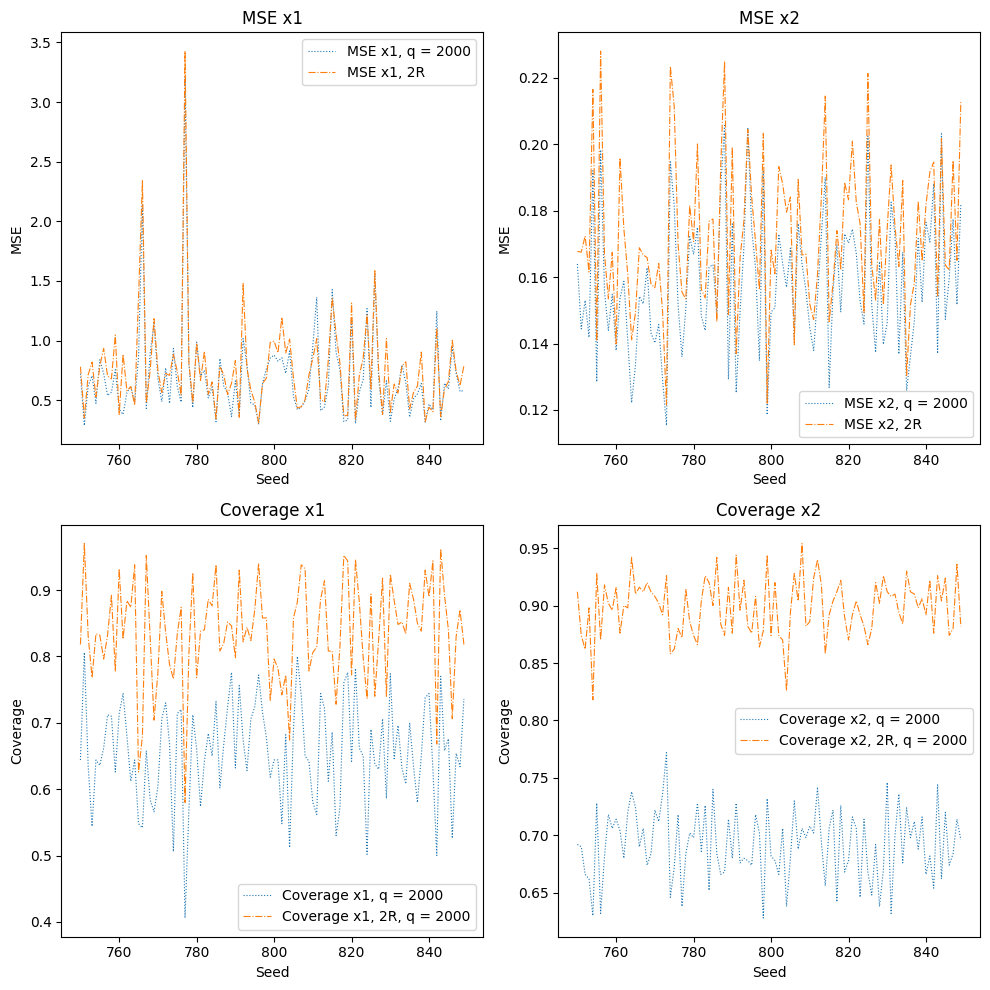

In [140]:
# Visualize the MSEs and coverage probabilities for x1 and x2 (seperate plots so total 4 plots)
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
seed = range(750, 750+num_experiments)

# Plot data in each subplot
axs[0, 0].plot(seed, MSE_x1_R_list, linestyle=':', linewidth=0.8, label=f"MSE x1, q = {ensemble_size}")
axs[0, 0].plot(seed, MSE_x1_R2_list, linestyle='-.', linewidth=0.8, label="MSE x1, 2R")
# axs[0, 0].plot(seed, MSE_x1Inf_list, linestyle='--', linewidth=0.8, label="MSE x1, inflation")
axs[0, 0].set_title("MSE x1")
axs[0, 0].set_xlabel("Seed")
axs[0, 0].set_ylabel("MSE")
axs[0, 0].legend()

axs[0, 1].plot(seed, MSE_x2_R_list, linestyle=':', linewidth=0.8, label=f"MSE x2, q = {ensemble_size}")
axs[0, 1].plot(seed, MSE_x2_R2_list, linestyle='-.', linewidth=0.8, label="MSE x2, 2R")
# axs[0, 1].plot(seed, MSE_x2Inf_list, linestyle='--', linewidth=0.8, label="MSE x2, inflation")
axs[0, 1].set_title("MSE x2")
axs[0, 1].set_xlabel("Seed")
axs[0, 1].set_ylabel("MSE")
axs[0, 1].legend()

axs[1, 0].plot(seed, coverage_x1_R_list, linestyle=':', linewidth=0.8, label=f"Coverage x1, q = {ensemble_size}")
axs[1, 0].plot(seed, coverage_x1_R2_list, linestyle='-.', linewidth=0.8, label=f"Coverage x1, 2R, q = {ensemble_size}")
# axs[1, 0].plot(seed, coverage_x1Inf_list, linestyle='--', linewidth=0.8, label="Coverage x1, inflation")
axs[1, 0].set_title("Coverage x1")
axs[1, 0].set_xlabel("Seed")
axs[1, 0].set_ylabel("Coverage")
axs[1, 0].legend()

axs[1, 1].plot(seed, coverage_x2_R_list, linestyle=':', linewidth=0.8, label=f"Coverage x2, q = {ensemble_size}")
axs[1, 1].plot(seed, coverage_x2_R2_list, linestyle='-.', linewidth=0.8, label=f"Coverage x2, 2R, q = {ensemble_size}")
# axs[1, 1].plot(seed, coverage_x2Inf_list, linestyle='--', linewidth=0.8, label="Coverage x2, inflation")
axs[1, 1].set_title("Coverage x2")
axs[1, 1].set_xlabel("Seed")
axs[1, 1].set_ylabel("Coverage")
axs[1, 1].legend()

plt.tight_layout()
plt.savefig(f"EnKF_MSE_coverage_Example1_q{ensemble_size}.png")
plt.show()


The figure implies that the estimates using $2R$ fluctuates less than that from the plain EnKF and the true states. This was expected in the simulation since simply using $2R$ deflates the estimates. 

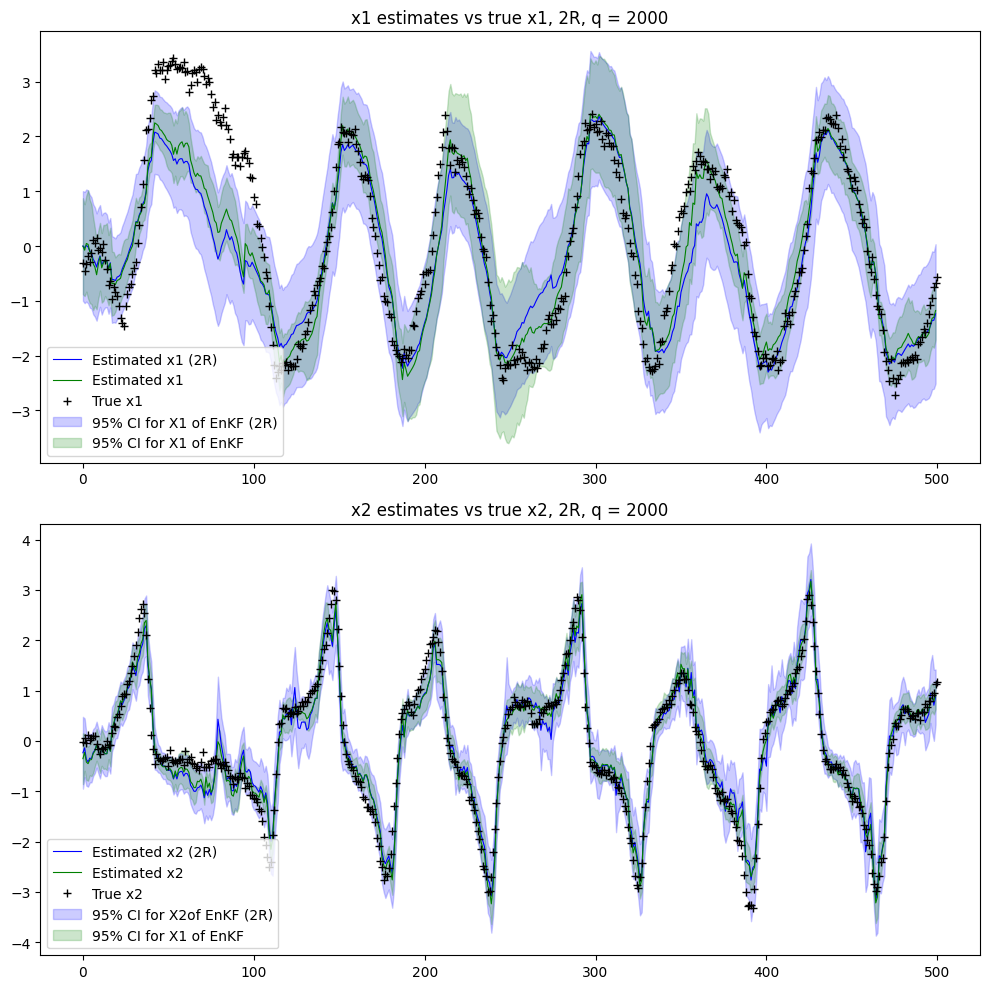

In [141]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot data in each subplot
axs[0].plot(result_x1_two, linestyle='-', linewidth=0.8, label="Estimated x1 (2R)", color='blue')
axs[0].plot(result_x1_30, linestyle='-', linewidth=0.8, label="Estimated x1", color='g')
axs[0].plot(true_states[:, 0], linestyle='None', marker='+', label="True x1", color="black")
axs[0].fill_between(range(T), np.array(result_x1_two) - np.array(var_x1_30_two), np.array(result_x1_two) + np.array(var_x1_30_two), alpha=0.2, color='blue', label="95% CI for X1 of EnKF (2R)")
axs[0].fill_between(range(T), np.array(result_x1_30) - np.array(var_x1_30), np.array(result_x1_30) + np.array(var_x1_30), alpha=0.2, color='g', label="95% CI for X1 of EnKF")
axs[0].set_title("x1 estimates vs true x1, 2R, q = " + str(ensemble_size))
axs[0].legend()

axs[1].plot(result_x2_two, linestyle='-', linewidth=0.8, label="Estimated x2 (2R)", color='blue')
axs[1].plot(result_x2_30, linestyle='-', linewidth=0.8, label="Estimated x2", color='g')
axs[1].plot(true_states[:, 1], linestyle='None', marker='+', label="True x2", color="black")
axs[1].fill_between(range(T), np.array(result_x2_two) - np.array(var_x2_30_two), np.array(result_x2_two) + np.array(var_x2_30_two), alpha=0.2, color='blue', label="95% CI for X2of EnKF (2R)")
axs[1].fill_between(range(T), np.array(result_x2_30) - np.array(var_x2_30), np.array(result_x2_30) + np.array(var_x2_30), alpha=0.2, color='g', label="95% CI for X1 of EnKF")
axs[1].set_title("x2 estimates vs true x2, 2R, q = " + str(ensemble_size))
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(f"EnKF_confidence_intervals_q{ensemble_size}.png")
plt.show()






We note that both cases capture the trend well. But the MSEs in the $2R$ case is slightly larger than that of the $R$ case. We also noticed that the intervals for $2R$ are wider and capture the true states better.

## Variance inflation visual (Not shown)

In [137]:

# # Visualize
# # Create a 2x2 grid of subplots
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# # Plot data in each subplot
# axs[0].plot(result_x1Inf, linestyle=':', label="Estimated x1 (Inflated)")
# axs[0].plot(result_x1_30, linestyle=':', linewidth=0.8, label="Estimated x1")
# axs[0].plot(true_states[:, 0], linestyle='None', marker='+', label="True x1", color="black")
# axs[0].set_title("x1 estimates vs true x1 (inflated) q = " + str(ensemble_size ))
# axs[0].legend()

# axs[1].plot(result_x2Inf, linestyle=':', linewidth=0.8, label="Estimated x2 (Inflated)")
# axs[1].plot(result_x2_30, linestyle=':', linewidth=0.8, label="Estimated x2")
# axs[1].plot(true_states[:, 1], linestyle='None', marker='+', label="True x2", color="black")
# axs[1].set_title("x2 estimates vs true x1 (inflated) q = " + str(ensemble_size ))
# axs[1].legend()

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()

# MSE_x1Inf = np.mean((np.array(result_x1Inf) - true_states[1:, 0])**2)
# MSE_x2Inf = np.mean((np.array(result_x2Inf) - true_states[1:, 1])**2)

# MSE_x1_30 = np.mean((np.array(result_x1_30) - true_states[1:, 0])**2)
# MSE_x2_30 = np.mean((np.array(result_x2_30) - true_states[1:, 1])**2)


In [138]:
# # Confidence intervals
# # Create a 2x2 grid of subplots
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# # Plot data in each subplot
# axs[0].plot(result_x1Inf, linestyle='-', linewidth=0.8, label="Estimated x1 (Inflated)", color='blue')
# axs[0].plot(result_x1_30, linestyle='-', linewidth=0.8, label="Estimated x1", color='g')
# axs[0].plot(true_states[:, 0], linestyle='None', marker='+', label="True x1", color="black")
# axs[0].fill_between(range(T), np.array(result_x1Inf) - np.array(var_x1_30Inf), np.array(result_x1Inf) + np.array(var_x1_30Inf), alpha=0.2, color='blue')
# axs[0].fill_between(range(T), np.array(result_x1_30) - np.array(var_x1_30), np.array(result_x1_30) + np.array(var_x1_30), alpha=0.2, color='g')
# axs[0].set_title("x1 estimates vs true x1 (inflated) q = " + str(ensemble_size))
# axs[0].legend()

# axs[1].plot(result_x2Inf, linestyle='-', linewidth=0.8, label="Estimated x2 (Inflated)", color='blue')
# axs[1].plot(result_x2_30, linestyle='-', linewidth=0.8, label="Estimated x2", color='g')
# axs[1].plot(true_states[:, 1], linestyle='None', marker='+', label="True x2", color="black")
# axs[1].fill_between(range(T), np.array(result_x2Inf) - np.array(var_x2_30Inf), np.array(result_x2Inf) + np.array(var_x2_30Inf), alpha=0.2, color='blue')
# axs[1].fill_between(range(T), np.array(result_x2_30) - np.array(var_x2_30), np.array(result_x2_30) + np.array(var_x2_30), alpha=0.2, color='g')
# axs[1].set_title("x2 estimates vs true x2 (inflated) q = " + str(ensemble_size))
# axs[1].legend()

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.savefig("EnKF_confidence_intervals_inflated.png")
# plt.show()


## LEnKF